# Identifying potential diabetes patients

In [166]:
import pandas as pd
import numpy as np
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [167]:
# read the data and establish a quick baseline
df = pd.read_csv('diabetes.csv')
print(df.info())
baseline = df.Outcome.sum()/df.shape[0]
print('Baseline: {:.2f}'.format(baseline))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
Baseline: 0.35


In [135]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


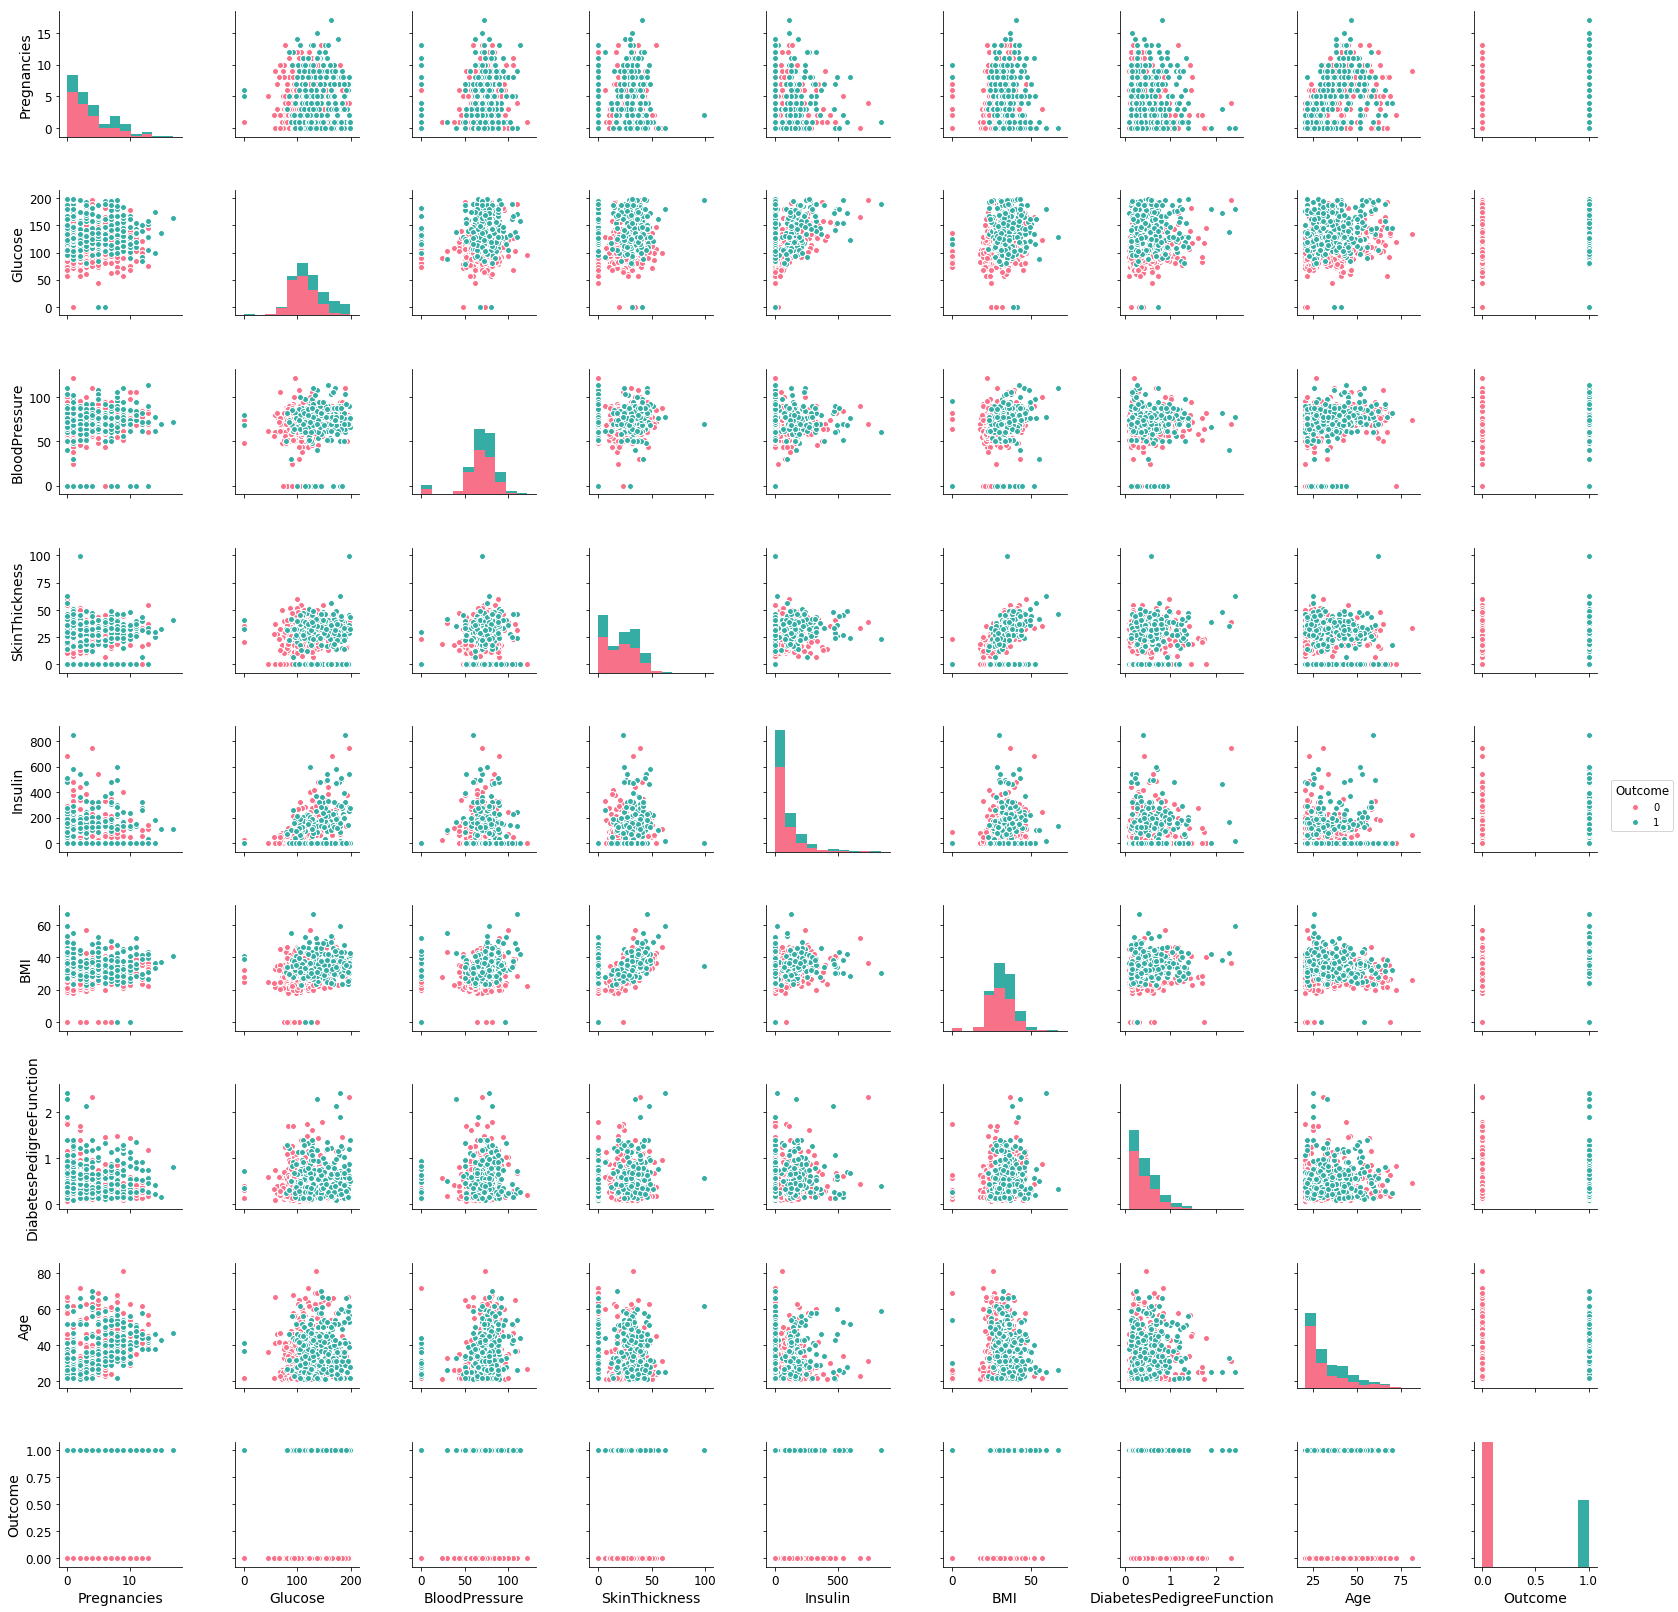

In [136]:
g = sns.pairplot(df, hue="Outcome", palette="husl")

Some of the factors like Glucose, insulin, Skin thickiness, BMI and Blood Pressure have value of zero. It is not possible to have a Blood pressure and BMI of zero. Most likely blank. There are also some outliers

A blood glucose level of less tha 40mg/dL might even stop brain function. 

In [137]:
# Creating a list of estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

1. Logictic regression is similar to linear regression, but the linear function is passed through a sigmoid function to get scores between 0 and 1.
2. Random forest classifier is an ensamble technique where multiple trees are generated based on random selection of features and data points. The goal is to minimize entropy which is a measure of uncertainty at any node
3. AdaBoostClassifier a forest of stumps. A stump is a tree where the prediction is done only on one feature. The misclassified data points are given more imporantance when the next stump is made. Finally, the prediciton is the combination of all stumps based on their weights which is measure of the stump's predictive power
4. GradientBoostingClassifier is slightly more complicated to explain. (watch Statquest)
5. KNN looks at the nearest neighbors to classify
6. SVC tries to find a boundary that best separates the data while maximizing the distance of the boundary separating the two classes.

In [138]:
# Creating a list of estimators
base_estimators = {
    'lr': LogisticRegression(max_iter=1000),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(),
    'svm': SVC(probability=True),
    'knn': KNeighborsClassifier(),
    'ab': AdaBoostClassifier(),
    'gbm': GradientBoostingClassifier()
}

In [139]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

In [140]:
# Splitting into X and y values
features = list(df.columns)
features.remove('Outcome')
X = df[features].values
y = df['Outcome'].values

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = df.Outcome)

# Using training set to furthur divide it for cross validation
# DataFrame to collect results
base_result_df = pd.DataFrame(None, columns = ['name', 'accuracy', 'recall', 'precision'])

# Loop over the estimators to look at performance without any hyperparameter tuning
for estimator_name in base_estimators:
    estimator = base_estimators[estimator_name]
    accuracy = cross_val_score(estimator, X_train, y_train, cv = 5, scoring='accuracy')
    precision = cross_val_score(estimator, X_train, y_train, cv = 5, scoring='precision')
    recall = cross_val_score(estimator, X_train, y_train, cv = 5, scoring='recall')
    base_result_df = base_result_df.append({
                                'name':  estimator_name,
                                'accuracy': round(accuracy.mean(),2),
                                'precision': round(precision.mean(),2),
                                'recall': round(recall.mean(),2)
                            }, ignore_index=True)

In [141]:
# Just a quick look at the results
base_result_df

,name,accuracy,recall,precision
0,lr,0.78,0.57,0.74
1,dt,0.69,0.57,0.55
2,rf,0.76,0.56,0.70
3,svm,0.76,0.48,0.74
4,knn,0.74,0.54,0.66
5,ab,0.75,0.57,0.67
6,gbm,0.75,0.57,0.67


## Some data cleaning 

<b>Attribute Information:</b>
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

/home/user_dsi_vnc/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Count after cleaning')

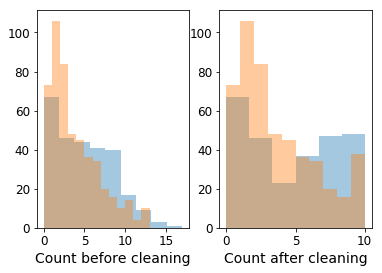

In [142]:
# Pregnanices
fig, axs = plt.subplots(ncols=2)
sns.distplot(df[df.Outcome==1].Pregnancies, kde=False, ax=axs[0])
sns.distplot(df[df.Outcome==0].Pregnancies, kde=False, ax=axs[0])
ax = axs[0]
ax.set_xlabel('Count before cleaning')

# For either of the classes. It seems a little farfected to have pregancies more than 12 times in a lifetime. 
# Lets cap this at 10. Any value above 10 is replaced with 10
df.loc[df.Pregnancies > 10, 'Pregnancies'] = 10
sns.distplot(df[df.Outcome==1].Pregnancies, kde=False, ax=axs[1])
sns.distplot(df[df.Outcome==0].Pregnancies, kde=False, ax=axs[1])
ax = axs[1]
ax.set_xlabel('Count after cleaning')

In [143]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

/home/user_dsi_vnc/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


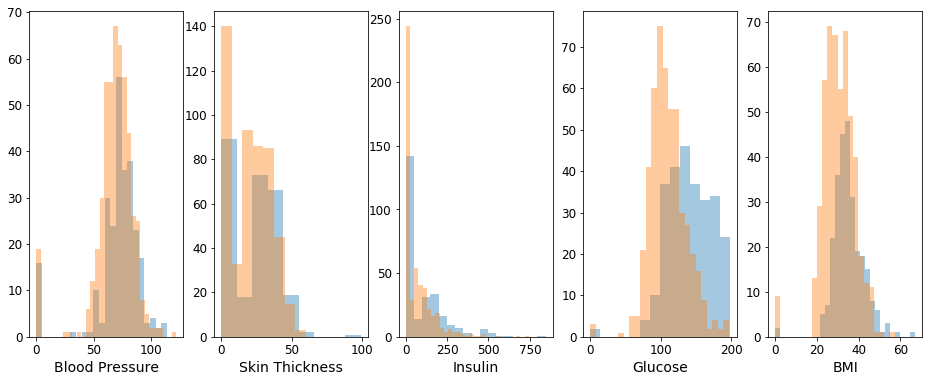

In [144]:
# Blood pressure
fig, axs = plt.subplots(ncols=5, figsize=(16,6))
def PlotHist(df, column_name, axes_label, axes_index, fig=fig, axs=axs):
    sns.distplot(df[df.Outcome==1][column_name], kde=False, ax=axs[axes_index])
    sns.distplot(df[df.Outcome==0][column_name], kde=False, ax=axs[axes_index])
    ax = axs[axes_index]
    ax.set_xlabel(axes_label)

PlotHist(df, 'BloodPressure', 'Blood Pressure', 0)
PlotHist(df, 'SkinThickness', 'Skin Thickness', 1)
PlotHist(df, 'Insulin', 'Insulin', 2)
PlotHist(df, 'Glucose', 'Glucose', 3)
PlotHist(df, 'BMI', 'BMI', 4)

# Clearly, a valyue of zero for a lot of these variables seem like a replacement for null, as blood pressure for
# anyone shouldn't be zero
# Let's use KNN imputation technique
def ReplaceWithNan(df, column_name):
    df.loc[df[column_name] == 0, column_name] = np.nan
    return df
df = ReplaceWithNan(df, 'BloodPressure')
df = ReplaceWithNan(df, 'SkinThickness')
df = ReplaceWithNan(df, 'Insulin')
df = ReplaceWithNan(df, 'Glucose')
df = ReplaceWithNan(df, 'BMI')
df.info()

In [174]:
# Lets try KNN imputation
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
knn_imputer = KNNImputer()
simple_imputer = SimpleImputer(strategy='median')
scalar = StandardScaler()

In [175]:
# Splitting into X and y values
features = list(df.columns)
features.remove('Outcome')
X = df[features].values
y = df['Outcome'].values

# Impute
X_knn = knn_imputer.fit_transform(X)
X_simple = simple_imputer.fit_transform(X)
X_knn = scalar.fit_transform(X_knn)
X_simple = scalar.fit_transform(X_simple)

# Test Train split
X_ki_train, X_ki_test, y_ki_train, y_ki_test = train_test_split(X_knn, y, test_size=0.2, stratify=df['Outcome'])
X_si_train, X_si_test, y_si_train, y_si_test = train_test_split(X_simple, y, test_size=0.2, stratify=df['Outcome'])

In [176]:
# Using training set to furthur divide it for cross validation
# DataFrame to collect results
result_ki_df = pd.DataFrame(None, columns = ['name', 'accuracy_ki', 'recall_ki', 'precision_ki'])

# Loop over the estimators to look at performance without any hyperparameter tuning
for estimator_name in base_estimators:
    estimator = base_estimators[estimator_name]
    accuracy = cross_val_score(estimator, X_ki_train, y_ki_train, cv = 5, scoring='accuracy')
    precision = cross_val_score(estimator, X_ki_train, y_ki_train, cv = 5, scoring='precision')
    recall = cross_val_score(estimator, X_ki_train, y_ki_train, cv = 5, scoring='recall')
    result_ki_df = result_ki_df.append({
                                'name':  estimator_name,
                                'accuracy_ki': round(accuracy.mean(),4),
                                'precision_ki': round(precision.mean(),4),
                                'recall_ki': round(recall.mean(),4)
                            }, ignore_index=True)

In [177]:
# Using training set to furthur divide it for cross validation
# DataFrame to collect results
result_si_df = pd.DataFrame(None, columns = ['name', 'accuracy_si', 'recall_si', 'precision_si'])

# Loop over the estimators to look at performance without any hyperparameter tuning
for estimator_name in base_estimators:
    estimator = base_estimators[estimator_name]
    accuracy = cross_val_score(estimator, X_si_train, y_si_train, cv = 5, scoring='accuracy')
    precision = cross_val_score(estimator, X_si_train, y_si_train, cv = 5, scoring='precision')
    recall = cross_val_score(estimator, X_si_train, y_si_train, cv = 5, scoring='recall')
    result_si_df = result_si_df.append({
                                'name':  estimator_name,
                                'accuracy_si': round(accuracy.mean(),4),
                                'precision_si': round(precision.mean(),4),
                                'recall_si': round(recall.mean(),4)
                            }, ignore_index=True)

In [178]:
result_df = base_result_df.merge(result_ki_df, on='name', how='inner')
result_df = result_df.merge(result_si_df, on='name', how='inner')

In [179]:
result_df

,name,accuracy,recall,precision,accuracy_ki,recall_ki,precision_ki,accuracy_si,recall_si,precision_si
0,lr,0.78,0.57,0.74,0.7769,0.5752,0.7303,0.7704,0.5748,0.7114
1,dt,0.69,0.57,0.55,0.6856,0.5841,0.5557,0.6905,0.5419,0.5478
2,rf,0.76,0.56,0.70,0.7655,0.6075,0.7093,0.7508,0.5699,0.6889
3,svm,0.76,0.48,0.74,0.7752,0.5651,0.7277,0.7656,0.5565,0.7098
4,knn,0.74,0.54,0.66,0.7654,0.5978,0.6893,0.6939,0.4958,0.5733
5,ab,0.75,0.57,0.67,0.7427,0.5658,0.6507,0.7296,0.5701,0.6214
6,gbm,0.75,0.57,0.67,0.7703,0.6217,0.6865,0.7460,0.5751,0.6556


## Building the model

In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
# Splitting into X and y values
features = list(df.columns)
features.remove('Outcome')
X = df[features].values
y = df['Outcome'].values

In [50]:
X.shape

(768, 8)

In [111]:
# Scaling the input values
normalizer = StandardScaler()
X = normalizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = df.Outcome )

In [112]:
LogisticRegression().get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [113]:
# Creating a simple linear regression classifier
classifier = LogisticRegression(penalty='l2', C=0.3)
classifier = classifier.fit(X_train, y_train)

# Predict using the classifier
y_pred = classifier.predict(X_train)

In [114]:
# Confusion matrix
def GetMetrics(y_train, y_pred):
    print('CLASSIFICATION REPORT:')
    print(classification_report(y_train, y_pred))

    print('CONFUSION MATRIX:')
    conf_mat = pd.DataFrame(confusion_matrix(y_train, y_pred), columns=['Positive', 'Negative'])
    print(conf_mat)

# For diabetes, or most medical test, a high recall is important as a False Positive isn't as bad as False negative

In [115]:
GetMetrics(y_train, y_pred)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       400
           1       0.73      0.57      0.64       214

    accuracy                           0.78       614
   macro avg       0.76      0.73      0.74       614
weighted avg       0.77      0.78      0.77       614

CONFUSION MATRIX:
   Positive  Negative
0       356        44
1        92       122


In [116]:
# Creating a simple Random Forest classifier
classifier = RandomForestClassifier()#(n_estimators=50, min_samples_split=6, max_depth=4, max_features=4)
classifier = classifier.fit(X_train, y_train)

# Predict using the classifier
y_pred = classifier.predict(X_train)

In [117]:
GetMetrics(y_train, y_pred)
# Could be a sign of overfitting. Lets build on Random Forest classifier and do some cross validation

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       214

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614

CONFUSION MATRIX:
   Positive  Negative
0       400         0
1         0       214


In [118]:
# Just to prove overfitting
y_pred = classifier.predict(X_test)
GetMetrics(y_pred, y_test) # Very poor compared to training

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       109
           1       0.57      0.69      0.63        45

    accuracy                           0.76       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.78      0.76      0.77       154

CONFUSION MATRIX:
   Positive  Negative
0        86        23
1        14        31


## Cross Validation and Grid Search SV

In [119]:
from sklearn.model_selection import cross_val_score

In [120]:
classifier = RandomForestClassifier(n_estimators=50, min_samples_split=6, max_depth=4, max_features=4)
y_scores = cross_val_score(classifier, X_train, y_train, cv=5)

In [121]:
y_scores

array([0.7804878 , 0.78861789, 0.72357724, 0.74796748, 0.73770492])

In [15]:
from sklearn.model_selection import GridSearchCV, cross_val_predict

In [16]:
classifier.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [25]:
# Creating a grid search object
parameters = {'max_features': [4,5,6,7], 
              'max_depth': [2,4,8,16], 
              'min_samples_split': [2,4,6,8], 
              'n_estimators': [50,100,200]}
classifier = GridSearchCV(RandomForestClassifier(), parameters)
classifier = classifier.fit(X_train, y_train)

In [26]:
classifier.best_params_

{'max_depth': 8,
 'max_features': 4,
 'min_samples_split': 6,
 'n_estimators': 100}

In [29]:
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100, 
                                                      max_depth=8, 
                                                      max_features=4, 
                                                      min_samples_split = 4
                                                     ), X_train, y_train, cv=5)

In [30]:
GetMetrics(y_train, y_pred) # Overall training scores are better compared to previous overfitting case

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       401
           1       0.71      0.63      0.67       213

    accuracy                           0.78       614
   macro avg       0.76      0.75      0.75       614
weighted avg       0.78      0.78      0.78       614

CONFUSION MATRIX:
   Positive  Negative
0       345        56
1        78       135


In [35]:
classifier = RandomForestClassifier(n_estimators=100, 
                                     max_depth=4, 
                                     max_features=4, 
                                     min_samples_split = 4)
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_train)
GetMetrics(y_pred, y_train) # Closer to training than the previous example

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.93      0.83      0.87       452
           1       0.63      0.83      0.71       162

    accuracy                           0.83       614
   macro avg       0.78      0.83      0.79       614
weighted avg       0.85      0.83      0.83       614

CONFUSION MATRIX:
   Positive  Negative
0       373        79
1        28       134


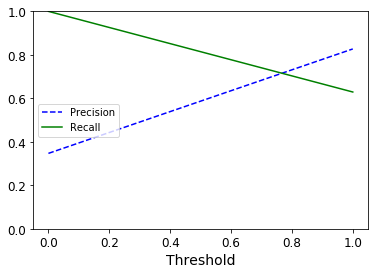

In [36]:
# Plotting the precision recall curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)
# Plot the precision recall graphs
def precision_recall_graph(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions, 'b--', label='Precision')
    plt.plot(thresholds, recalls,'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim(0,1)

precision_recall_graph(precisions[:-1], recalls[:-1], thresholds)
plt.show()

Text(0,0.5,'Precision')

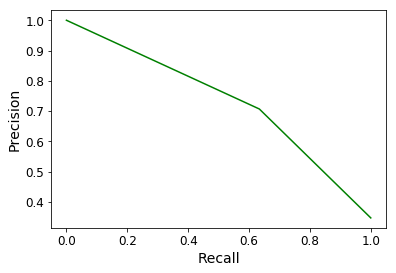

In [32]:
plt.plot(recalls, precisions, 'g-')
plt.xlabel('Recall')
plt.ylabel('Precision')

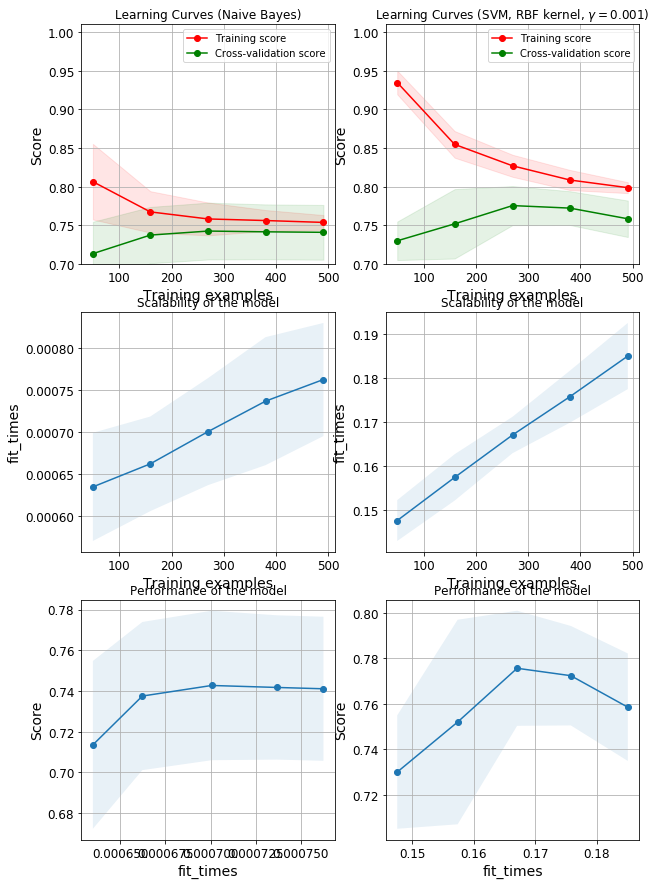

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(n_estimators=100, 
                                     max_depth=3, 
                                     max_features=6, 
                                     min_samples_split = 8)
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()